In [ ]:
# ANALYSE DECRIPTIVE DES ACTIONS - CLTHS ET MINES
# Dans ce code je calcul les statistiques descriptives annuelles des deux industries(rendement, volatilité, Sharpe) pour deux actions (Clths et Mines)
import numpy as np
import pandas as pd


actions = ["Clths", "Mines"]

pf = pd.read_csv(
    "c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv",
    index_col=0
)

ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv",index_col=0)



#Je regroupe les deux bases pour avoir les taux sans risque RF et les rendements Ri,t des actions dans une même base
data = pf[actions].join(ff[["RF"]], how="inner").dropna() # 
data = data.sort_index()

R = data[actions] / 100.0     # rendements mensuels en décimal
rf = data["RF"] / 100.0       # taux sans risque mensuel

# ici  je calcule les statistiques annuelles 
ANNUAL = 12 # car j'ai des données mensuelles

mu_m = R.mean()  # esperance de rendement mensuelle 
Sigma_m = R.cov() # covariance mensuelle

mu_a = mu_m * ANNUAL # j'annualise les rendements
Sigma_a = Sigma_m * ANNUAL
rf_a = rf.mean() * ANNUAL

# volatilités annuelles
sigma_a = np.sqrt(np.diag(Sigma_a))

# ratios de Sharpe
sharpe = (mu_a - rf_a) / sigma_a
# dataframe de sortie des statistiques descriptives annuelles
# -----  Analyse des industries  --------
stats_descriptives = pd.DataFrame({
    "Rendement_annuel": mu_a,
    "Volatilite_annuelle": sigma_a,
    "Sharpe_annuel": sharpe
}, index=actions)

print("Statistiques annuelles (Clths & Mines) ")
print(stats_descriptives)

# Bonus: considérons un marché avec seulement ces deux actions
#Ici je calcule le Portefeuille tangent selon la théorie moderne du portefeuille(portefeuille qui maximise le ratio de Sharpe)

ones = np.ones(len(actions))
excess_mu = mu_a.values - rf_a * ones

w_tan_unnorm = np.linalg.inv(Sigma_a.values) @ excess_mu
w_tan = w_tan_unnorm / (ones @ w_tan_unnorm)

mu_tan = w_tan @ mu_a.values
sig_tan = np.sqrt(w_tan @ Sigma_a.values @ w_tan) 
sharpe_tan = (mu_tan - rf_a) / sig_tan

#print("\nPortefeuille tangent")
#print("Poids (Clths, Mines) =", w_tan)
#print("Rendement annuel =", mu_tan)
#print("Volatilité annuelle =", sig_tan)
#print("Sharpe annuel =", sharpe_tan)


Statistiques annuelles (Clths & Mines) 
       Rendement_annuel  Volatilite_annuelle  Sharpe_annuel
Clths          0.119495             0.228402       0.332147
Mines          0.136444             0.261434       0.355013


In [ ]:
# Dans cette partie nous allons faire une regression CAPM pour  nos deux industries (Clths et Mines)
# Regression et estimation des coefficients et calcule des statistique de Student pour verifier la significativité des estimateurs ou coefficients

betas = [] # betas est une liste qui va contenir les coefficients beta de chaque action
alphas = [] # alphas est une liste qui va contenir les coefficients alpha de chaque action
t_stats_alpha = [] # liste des t-stats pour alpha
t_stats_beta = [] # liste des t-stats pour beta

for action_i in actions: # cette boucle fait les regressions pour chaque action
    Y = PR[action_i].values
    X = np.column_stack((np.ones(len(Y)), PRM))  # constante + facteur marché

    # estimateurs MCO
    theta_i = np.linalg.inv(X.T @ X) @ X.T @ Y # cette fonctionnalité calcule les coefficients de la regression OLS
    alpha_i, beta_i = theta_i # on extrait alpha et beta
    alphas.append(alpha_i) # j'ajoute l'alpha à la liste
    betas.append(beta_i) # j'ajoute le beta à la liste

    #  calcul des résidus, variance résiduelle,covariance et t-stats
    eps_i = Y - X @ theta_i # on extrait les résidus
    sig2_eps_i = np.sum(eps_i**2) / (len(Y) - X.shape[1]) # sig2_eps_i est la variance des résidus ajustée aux degres de liberté
    cov_theta_i = sig2_eps_i * np.linalg.inv(X.T @ X) # matrice de covariance des estimateurs

    se_theta_i = np.sqrt(np.diag(cov_theta_i)) # ecart-type des estimateurs
    t_alpha_i, t_beta_i = theta_i / se_theta_i # ici on divise le coefficient par son ecart-type pour obtenir le t-stats( statistique de student)
    t_stats_alpha.append(t_alpha_i) # j'ajoute le t-stats d'alpha à la liste
    t_stats_beta.append(t_beta_i) # j'ajoute le t-stats de beta à la liste


#  je créé le dataframe de sortie  pour afficher les résultats annuels de la regression CAPM sans oublieé d'anualiser le alpha et l'espérance de la prime de risque

ANNUAL = 12
# ----Resultats de la regression CAPM ----
capm_annual = pd.DataFrame({
    "Alpha": np.array(alphas) * ANNUAL,
    "Beta": betas,
    "t_alpha": [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats_alpha],
    "t_beta":  [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats_beta],
    "E[ri]-E[rf]": PR.mean() * ANNUAL 
}, index=actions)

print(capm_annual)


          Alpha      Beta t_alpha  t_beta  E[ri]-E[rf]
Clths -0.497343  1.129297   -0.26  32.29*      7.58631
Mines  1.137464  1.137695    0.46  24.76*      9.28123


In [ ]:
# Ici on calcule le coefficient de détermination R² pour chaque industrie dans le cadre du modèle CAPM
actions = ["Clths", "Mines"]

# Données
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

data = pf[actions].join(ff[["RF","Mkt-RF"]], how="inner").dropna()

Rt = data[actions].subtract(data["RF"], axis=0).values
Ft = data[["Mkt-RF"]].values

T = Rt.shape[0]

print("=== R² CAPM ===")

for p, name in enumerate(actions):
    Y = Rt[:, p]
    X = np.column_stack((np.ones(T), Ft))

    beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    Y_hat = X @ beta

    SSR = np.sum((Y - Y_hat)**2)
    SST = np.sum((Y - Y.mean())**2)

    R2 = 1 - SSR / SST
    print(f"{name} : R² = {R2:.4f}")



=== R² CAPM ===
Clths : R² = 0.5829
Mines : R² = 0.4510


DATA min_max: 1963-07-01 00:00:00 2025-10-01 00:00:00

 Fama-French 3 — Résultats ( alpha mensuel)

          Alpha  Beta_MKT  Beta_SMB  Beta_HML t_alpha   t_MKT  t_SMB  t_HML  \
Clths -1.744180  1.088078  0.379839  0.217629   -0.96  30.64*  7.42*  4.24*   
Mines -0.635336  1.126591  0.316681  0.350715   -0.26  23.75*  4.63*  5.12*   

       E[ri]-E[rf]  
Clths      7.58631  
Mines      9.28123  


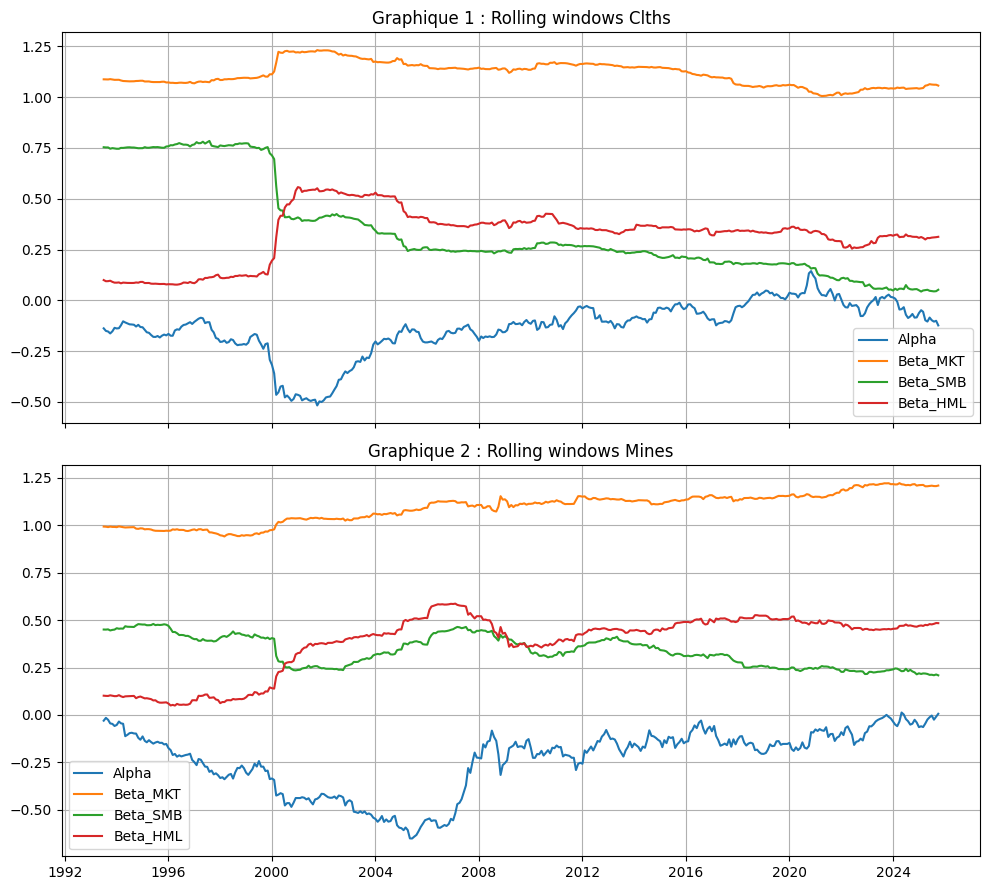

In [ ]:

#ici on estime le modele Fama et French à 3 facteurs: c'est à dire on explique les rendements des actifs par les facteurs marché, le facteur Small Minus Big (SMB) et le facteur High Minus Low (HML)
# Ici je fais l'estimation en calculant les coefficients (associé aux facteurs marché, taille et value) . 
# Ensuite je determineles t-stats de student pour evaluer la significativité des coefficients
# et enfin je fais rolling window pour determiner l'évolution des coefficients dans le temps

pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)

ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv",index_col=0)



#Je regroupe les deux bases pour avoir les taux sans risque RF et les rendements Ri,t des actions dans une même base
data = pf[actions].join(ff[["RF"]], how="inner").dropna() # 
data = data.sort_index()

R = data[actions] / 100.0     # rendements mensuels en décimal
rf = data["RF"] / 100.0       
import matplotlib.pyplot as plt

actions = ["Clths", "Mines"]

# 1 Transformation des dates au format datetime pour pouvoir travailler correctement sur le temps
pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

# Jointure des rendements des portefeuilles avec les facteurs du modèle FF3
# On supprime les observations manquantes pour avoir des séries bien alignées
data = pf[actions].join(ff[["RF", "Mkt-RF", "SMB", "HML"]], how="inner").dropna().sort_index()

# Affichage de la période couverte par les données
print("DATA min_max:", data.index.min(), data.index.max())

# Construction des rendements excédentaires Rt et de la matrice des facteurs Ft
# Rt correspond à Ri - Rf pour chaque portefeuille
# Ft contient les trois facteurs du modèle FF3
Rt = data[actions].subtract(data["RF"], axis=0).values
Ft = data[["Mkt-RF", "SMB", "HML"]].values


T = Rt.shape[0]  # nombre d'observations
nb_pf = Rt.shape[1] # nombre de portefeuilles
k = Ft.shape[1] + 1  # alpha + 3 betas


# 2) Estimation FF3 (Fama et French à 3 facteurs)

X = np.column_stack((np.ones(T), Ft))
beta_full = np.linalg.inv(X.T @ X) @ (X.T @ Rt)


# 3) Inférence statistique 

XtX_inv = np.linalg.inv(X.T @ X) # matrice inverse de X'X pour le calcul des variances

alphas, betas = beta_full[0], beta_full[1:] # on extrait les alphas et les betas
t_stats = np.zeros(beta_full.shape) # on inicialise les t-stats

for p in range(nb_pf): # boucle qui calcule les t-stats pour chaque portefeuille
    Yp = Rt[:, p] # Yt est le vecteur des rendements excédentaires du portefeuille p
    theta = beta_full[:, p] # on extrait les coefficients estimés pour le portefeuille p
    eps = Yp - X @ theta # résidus de la régression
    sigma2 = np.sum(eps**2) / (T - k)# variance résiduelle ajustée aux degrés de liberté
    cov_theta = sigma2 * XtX_inv # matrice de covariance des estimateurs
    se = np.sqrt(np.diag(cov_theta)) # écart-type des estimateurs
    t_stats[:, p] = theta / se # t-stats : coefficient divisé par son écart-type


# 4 dataframe final

ANNUAL = 12
#---Resultats de la regression FF3 ----
ff3_results = pd.DataFrame({
    "Alpha": alphas * ANNUAL,
    "Beta_MKT": betas[0],
    "Beta_SMB": betas[1],
    "Beta_HML": betas[2],
    "t_alpha": [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[0]], # on ajoute une étoile si le t-stat est significatif au seuil 5%
    "t_MKT":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[1]],
    "t_SMB":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[2]],
    "t_HML":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[3]],
    "E[ri]-E[rf]": data[actions].subtract(data["RF"], axis=0).mean() * ANNUAL
}, index=actions)

print("\n Fama-French 3 — Résultats ( alpha mensuel)\n")
print(ff3_results)

# 5 Ici on fait le rolling window pour observer l'évolution des coefficients dans le temps
RW = 360
# pour chaque position de la fenêtre glissante, on calcule les coefficients de la régression FF3

resultats_rw = np.zeros((T - RW , k, nb_pf))

for j in range(T - RW ):
    Xw = np.column_stack((np.ones(RW), Ft[j:j+RW, :])) # matrice des facteurs dans la fenêtre glissante
    for p in range(nb_pf): #
        Yw = Rt[j:(j+RW), p]
        resultats_rw[j, :, p] = np.linalg.inv(Xw.T @ Xw) @ (Xw.T @ Yw) 


# ==== 6) Graphiques 1 et 2  du rolling windows de clths et Mines ====
dates = ff.index[RW:]

fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True) 
axes = axes.flatten()
for p in range(nb_pf):
    ax = axes[p]
    labels_beta=["Alpha", "Beta_MKT", "Beta_SMB", "Beta_HML"]
    for b in range(k): 
        axes[p].plot(dates, resultats_rw[:, b, p], label=labels[b]) 
        axes[p].set_title(f"Graphique {p+1} : Rolling windows {actions[p]}") 
        axes[p].grid(True)
        axes[p].legend() 
plt.tight_layout()
plt.show()


In [ ]:
# on calcule le coefficient de détermination R² pour chaque industrie dans le cadre du modèle Fama-French 3 facteurs
# Données
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

data = pf[actions].join(ff[["RF","Mkt-RF","SMB","HML"]], how="inner").dropna()
Rt = data[actions].subtract(data["RF"], axis=0).values
Ft = data[["Mkt-RF","SMB","HML"]].values

T = Rt.shape[0]

print("\n=== R² FF3 ===")

for p, name in enumerate(actions):
    Y = Rt[:, p]
    X = np.column_stack((np.ones(T), Ft))

    beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    Y_hat = X @ beta

    SSR = np.sum((Y - Y_hat)**2)
    SST = np.sum((Y - Y.mean())**2)

    R2 = 1 - SSR / SST
    print(f"{name} : R² = {R2:.4f}")



=== R² FF3 ===
Clths : R² = 0.6225
Mines : R² = 0.4865


In [ ]:

# Test de stabilité de Chow (rupture en 2000) pour le modèle FF3 
# L’objectif est de vérifier si les coefficients du modèle changent avant et après l’an 2000
#Le test de Chow est utilisé afin de vérifier la stabilité des coefficients du modèle Fama-French à trois facteurs autour de l’an 2000. L’échantillon est scindé en deux sous-périodes, avant et après 2000, et le modèle est estimé séparément sur chacune d’elles ainsi que sur l’échantillon complet. L’idée est de comparer la capacité explicative d’un modèle à coefficients constants avec celle de deux modèles autorisant des coefficients différents selon les périodes. Une statistique de Chow élevée indique que les paramètres du modèle ne sont pas stables dans le temps et qu’une rupture structurelle est présente. Les résultats montrent que les expositions aux facteurs de risque évoluent au cours du temps, ce qui confirme que la relation entre rendements sectoriels et facteurs Fama-French n’est pas constante sur l’ensemble de la période étudiée.
# L’hypothèse de stabilité des coefficients est rejetée lorsque la statistique de Chow est supérieur à la valeur critique de la loi de Fisher ( > 3.98) au seuil de 5 %.
import numpy as np
import pandas as pd

actions = ["Clths", "Mines"]

# chargement des données de rendements des portefeuilles et des facteurs Fama-French
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("C:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

# Transformation des dates au format datetime pour pouvoir travailler correctement sur le temps
pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

# Jointure des rendements des portefeuilles avec les facteurs du modèle FF3
# On supprime les observations manquantes pour avoir des séries bien alignées
data = pf[actions].join(ff[["RF", "Mkt-RF", "SMB", "HML"]], how="inner").dropna().sort_index()


# Construction des rendements excédentaires Rt et de la matrice des facteurs Ft
# Rt correspond à Ri - Rf pour chaque portefeuille
# Ft contient les trois facteurs du modèle FF3
Rt = data[actions].subtract(data["RF"], axis=0).values
Ft = data[["Mkt-RF", "SMB", "HML"]].values


# On sépare les données en deux sous-périodes avant et après 2000
split_date = pd.Timestamp("2000-01-01")
idx_pre = data.index < split_date
idx_post = data.index >= split_date

# k correspond au nombre de paramètres du modèle
# ici k = 4 car on a une constante  et trois bêtas

k = Ft.shape[1] + 1
nb_pf = Rt.shape[1]

# Cette fonction estime les coefficients du modèle par moindres carrés
# et qui calcule la somme des carrés des résidus
def coef_scr(Y, F):
    X = np.column_stack((np.ones(len(Y)), F))
    theta, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)
    eps = Y - X @ theta
    SCR = float(np.sum(eps**2))
    return theta, SCR

# Application du test de Chow portefeuille par portefeuille
for p in range(nb_pf):
    name = actions[p]

    # Estimation du modèle sur l’échantillon complete
    Y_full = Rt[:, p]
    theta_full, SCR_full = coef_scr(Y_full, Ft)

    # Estimation du modèle avant 2000
    Y_pre = Rt[idx_pre, p]
    F_pre = Ft[idx_pre, :]
    theta_pre, SCR_pre = coef_scr(Y_pre, F_pre)

    # Estimation du modèle après 2000
    Y_post = Rt[idx_post, p]
    F_post = Ft[idx_post, :]
    theta_post, SCR_post = coef_scr(Y_post, F_post)

    # Tailles des deux sous-échantillons
    T1 = len(Y_pre)
    T2 = len(Y_post)

    print(f"\n {name} ")
    print("T1 (avant 2000) =", T1, "| T2 (après 2000) =", T2)

    # Vérification que chaque sous-échantillon contient assez d’observations
    if T1 <= k or T2 <= k:
        print("Sous-échantillon trop court pour estimer FF3 (k=4).")
        continue

    # statistique de Chow
    # Elle compare la qualité d’ajustement du modèle avant et après la rupture
    num = (SCR_full - (SCR_pre + SCR_post)) / k
    den = (SCR_pre + SCR_post) / (T1 + T2 - 2 * k)
    F_chow = num / den

    # Calcul de l’écart-type des coefficients estimés avant et après 2000
    # Cela permet de voir quels paramètres varient le plus entre les deux périodes
    std_beta = np.vstack([theta_pre, theta_post]).std(axis=0, ddof=1)
     # ---Resultats du test de Chow ff3----
    print("Statistique de Chow (F) :", F_chow)
    print("Ecart-type (alpha, MKT, SMB, HML) :")
    print(std_beta)



 Clths 
T1 (avant 2000) = 438 | T2 (après 2000) = 310
Statistique de Chow (F) : 15.597186607635264
Ecart-type (alpha, MKT, SMB, HML) :
[0.23557034 0.00352091 0.51732056 0.11918727]

 Mines 
T1 (avant 2000) = 438 | T2 (après 2000) = 310
Statistique de Chow (F) : 3.8889702690933
Ecart-type (alpha, MKT, SMB, HML) :
[0.32317136 0.19286632 0.21636689 0.2179078 ]


          Alpha  Beta_MKT  Beta_SMB  Beta_HML  Beta_RMW  Beta_CMA t_alpha  \
Clths -4.389899  1.121608  0.540179  0.158259  0.677389  0.047805  -2.52*   
Mines -1.424936  1.148312  0.346561  0.267838  0.111867  0.172444   -0.58   

        t_MKT   t_SMB  t_HML  t_RMW t_CMA  E[ri]-E[rf]  
Clths  32.03*  10.61*  2.41*  9.90*  0.49      7.58631  
Mines  23.09*   4.79*  2.88*   1.15  1.24      9.28123  


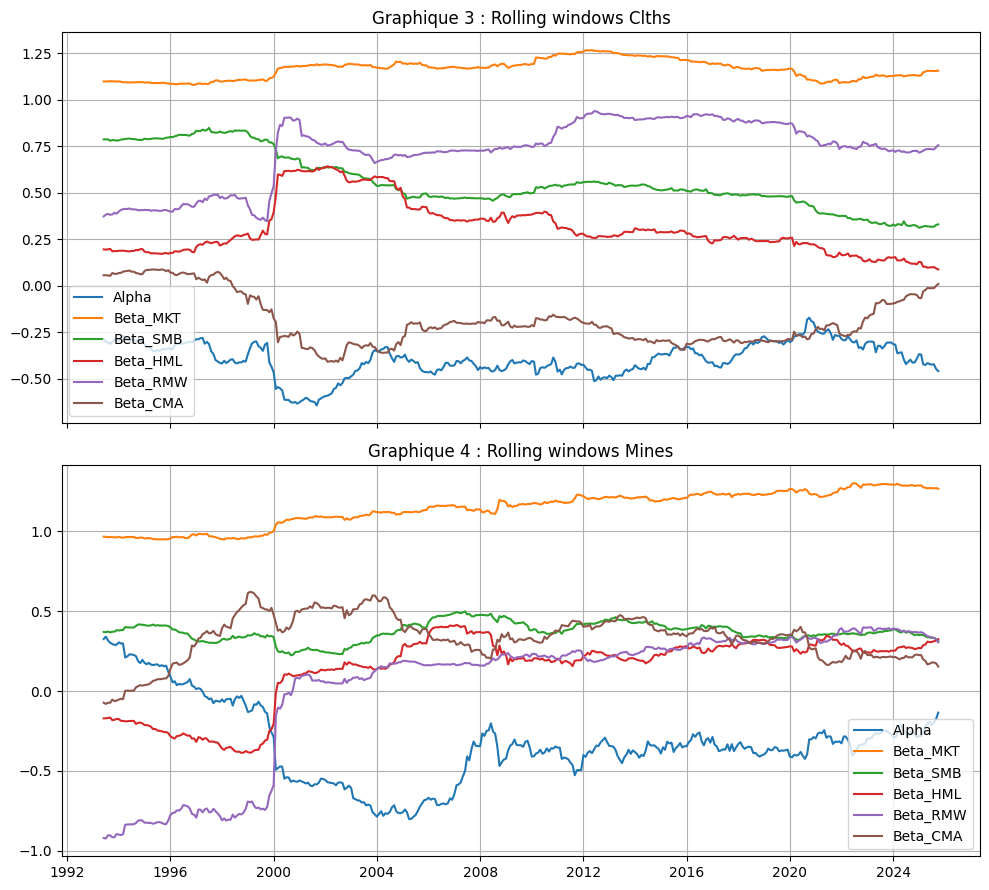

In [ ]:
# Modèle de Fama-French à cinq facteurs
# l’objectif est d’expliquer les rendements excédentaires des portefeuilles Clths et Mines
# en tenant compte de cinq sources de risque systématique et d’étudier leur stabilité dans le temps

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Définition des deux portefeuilles sectoriels étudiés
actions = ["Clths", "Mines"]

# Chargement des données de rendements des portefeuilles et des facteurs Fama-French
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

# Transformation des dates au format datetime pour assurer une bonne gestion temporelle
pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

# Nettoyage des données en supprimant les valeurs manquantes codées -99.99
pf.columns = pf.columns.str.strip()
pf = pf.replace(-99.99, np.nan)

# Jointure des rendements des portefeuilles avec les cinq facteurs du modèle FF5
# On conserve uniquement les observations communes afin d’avoir des séries parfaitement alignées
data = pf[actions].join(
    ff[["RF","Mkt-RF","SMB","HML","RMW","CMA"]],
    how="inner"
).dropna().sort_index()

# Construction des rendements excédentaires
# Rt correspond au rendement du portefeuille au-dessus du taux sans risque
Rt = data[actions].subtract(data["RF"], axis=0).values

#la matrice des facteurs de risque
# Mkt-RF represente  le risque de marché
# SMB le risque lié à la taille
# HML le risque value
# RMW la profitabilité
# CMA la politique d’investissement
Ft = data[["Mkt-RF","SMB","HML","RMW","CMA"]].values

# dimensions du problème
# T est le nombre de périodes
# nb_pf est le nombre de portefeuilles
# k est le nombre de paramètres estimés dans le modèle
T = Rt.shape[0]
nb_pf = Rt.shape[1]
k = Ft.shape[1] + 1

# Estimation du modèle FF5 sur l’ensemble de l’échantillon
# On utilise la méthode des moindres carrés ordinaires sous forme matricielle
X = np.column_stack((np.ones(T), Ft))
beta_full = np.linalg.inv(X.T @ X) @ (X.T @ Rt)

# Cette étape permet de mesurer l’incertitude statistique associée aux coefficients estimés
# On calcule les résidus, la variance résiduelle et les statistiques t
XtX_inv = np.linalg.inv(X.T @ X)
t_stats = np.zeros(beta_full.shape)

for p in range(nb_pf):
    Yp = Rt[:, p]
    theta = beta_full[:, p]
    eps = Yp - X @ theta
    sigma2 = np.sum(eps**2) / (T - k)
    cov_theta = sigma2 * XtX_inv
    se = np.sqrt(np.diag(cov_theta))
    t_stats[:, p] = theta / se

#on construit letableau récapitulatif des résultats
# on annualise l'alpha pour pouvoir l'estimer 
# Les bêtas mesurent la sensibilité du portefeuille aux différents facteurs
# les statistiques t permettent de tester la significativité des coefficients

# ---Résultat de la regression fama french à 5 facteurs----
ANNUAL = 12
ff5_results = pd.DataFrame({
    "Alpha": beta_full[0] * ANNUAL,
    "Beta_MKT": beta_full[1],
    "Beta_SMB": beta_full[2],
    "Beta_HML": beta_full[3],
    "Beta_RMW": beta_full[4],
    "Beta_CMA": beta_full[5],
    "t_alpha": [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[0]],
    "t_MKT":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[1]],
    "t_SMB":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[2]],
    "t_HML":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[3]],
    "t_RMW":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[4]],
    "t_CMA":   [f"{t:.2f}*" if abs(t) > 1.96 else f"{t:.2f}" for t in t_stats[5]],
    "E[ri]-E[rf]": data[actions].subtract(data["RF"], axis=0).mean() * ANNUAL
}, index=actions)


print(ff5_results)

# estimation du modèle FF5 en fenêtres glissantes de 360 mois
# Cette approche permet d’étudier l’évolution dans le temps des expositions aux facteurs
RW = 360
resultats_rw = np.zeros((T - RW + 1, k, nb_pf))

for j in range(T - RW + 1):
    Xw = np.column_stack((np.ones(RW), Ft[j:j+RW]))
    for p in range(nb_pf):
        Yw = Rt[j:j+RW, p]
        resultats_rw[j, :, p] = np.linalg.inv(Xw.T @ Xw) @ (Xw.T @ Yw)

# Représentation graphique des coefficients estimés en rolling window
# Les graphiques permettent de visualiser la stabilité ou les ruptures dans les expositions aux facteurs
dates = ff.index[RW - 1:]
labels = ["Alpha","Beta_MKT","Beta_SMB","Beta_HML","Beta_RMW","Beta_CMA"] 

fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)
axes = axes.flatten()

for p in range(nb_pf):
    
    for b in range(k):
        axes[p].plot(dates, resultats_rw[:, b, p], label=labels[b])
    axes[p].set_title(f"Graphique {p+3} : Rolling windows {actions[p]}")
    axes[p].grid(True)
    axes[p].legend() 

plt.tight_layout()
plt.show()


In [ ]:
#Ici on calcule le coefficient de détermination R² pour chaque industrie dans le cadre du modèle Fama-French à cinq facteurs
actions = ["Clths", "Mines"]

# Données
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

data = pf[actions].join(ff[["RF","Mkt-RF","SMB","HML","RMW","CMA"]], how="inner").dropna()

Rt = data[actions].subtract(data["RF"], axis=0).values
Ft = data[["Mkt-RF","SMB","HML","RMW","CMA"]].values

T = Rt.shape[0]

print("\n=== R² FF5 ===")

for p, name in enumerate(actions):
    Y = Rt[:, p]
    X = np.column_stack((np.ones(T), Ft))

    beta = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    Y_hat = X @ beta

    SSR = np.sum((Y - Y_hat)**2)
    SST = np.sum((Y - Y.mean())**2)

    R2 = 1 - SSR / SST
    print(f"{name} : R² = {R2:.4f}")



=== R² FF5 ===
Clths : R² = 0.6670
Mines : R² = 0.4881


In [ ]:
import numpy as np
import pandas as pd

# Test de stabilité de Chow (rupture en 2000) pour le modèle FF5 ( on ajoute seulement les facteurs investissement(CMA) et profitabilité(RMW) au modèle FF3)
# L’objectif est de vérifier si les coefficients du modèle FF5 changent de manière significative avant et après l’an 2000

# chargement des données de rendements des portefeuilles et des facteurs Fama-French
pf = pd.read_csv("c:/Users/User/Documents/evalactif/seance1eval/Portefeuilles_Industries_49 (1).csv", index_col=0)
ff = pd.read_csv("C:/Users/User/Documents/evalactif/seance1eval/FamaFrench_5F (1).csv", index_col=0)

# Conversion des dates au format datetime pour manipuler correctement les périodes
# les fichiers sont en format YYYYMM, donc on impose le format pour éviter des erreurs
pf.index = pd.to_datetime(pf.index.astype(str), format="%Y%m")
ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")


# on choisit les deux portefeuilles sectoriels étudiés
actions = ["Clths", "Mines"]

# jointure des rendements des portefeuilles avec les facteurs FF5 et le taux sans risque
# On garde uniquement les dates communes et on supprime les lignes incomplètes
data = pf[actions].join(ff[["RF", "Mkt-RF", "SMB", "HML", "RMW", "CMA"]], how="inner").dropna()
data = data.sort_index()


# construction des rendements excédentaires
Rt = data[actions].subtract(data["RF"], axis=0).values

# Construction de la matrice des facteurs FF5
# Mkt-RF représente le risque de marché
# SMB correspond au facteur taille
# HML correspond au facteur value
# RMW correspond à la profitabilité
# CMA correspond à l’investissement
Ft = data[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].values


# L’idée est de comparer les coefficients estimés avant 2000 et après 2000
split_date = pd.Timestamp("2000-01-01")
idx_pre = data.index < split_date
idx_post = data.index >= split_date

# k est le nombre de paramètres estimés dans le modèle
# Ici k = 6 car on a une constante (alpha) et cinq bêtas
k = Ft.shape[1] + 1
nb_pf = Rt.shape[1]

# fonction qui estime les coefficients par moindres carrés et calcule la somme des carrés des résidus
# La somme des carrés des résidus mesure l’erreur totale du modèle sur la période considérée
def ols_theta_ssr_lstsq(Y, F): # Y est le vecteur des rendements excédentaires, F est la matrice des facteurs
    X = np.column_stack((np.ones(len(Y)), F)) # on ajoute la constante au modèle
    theta, _, _, _ = np.linalg.lstsq(X, Y, rcond=None) # estimation des coefficients par moindres carrés
    eps = Y - X @ theta
    SSR = float(np.sum(eps**2)) # somme des carrés des résidus
    return theta, SSR

# application du test de Chow portefeuille par portefeuille
for p in range(nb_pf):
    name = actions[p]

    # estimation sur l’échantillon complet
    # Cela sert de référence pour comparer avec la somme des deux sous-échantillons
    Y_full = Rt[:, p]
    theta_full, SSR_full = ols_theta_ssr_lstsq(Y_full, Ft)

    # estimation avant 2000
    Y_pre = Rt[idx_pre, p]
    F_pre = Ft[idx_pre, :]
    theta_pre, SSR_pre = ols_theta_ssr_lstsq(Y_pre, F_pre)

    # estimation après 2000
    Y_post = Rt[idx_post, p]
    F_post = Ft[idx_post, :]
    theta_post, SSR_post = ols_theta_ssr_lstsq(Y_post, F_post)

    # Tailles des deux sous-échantillons
    T1 = len(Y_pre)
    T2 = len(Y_post)

    print(f"\n {name} ")
    print("T1 (avant 2000) =", T1, "| T2 (après 2000) =", T2)

    # Vérification qu’on a assez d’observations pour estimer le modèle dans chaque sous-période
    if T1 <= k or T2 <= k:
        print("Sous-échantillon trop court pour estimer FF5 (k=6).")
        continue

    # Calcul de la statistique de Chow
    # Si la statistique est élevée, cela signifie que les coefficients ne sont pas stables entre les deux périodes
    num = (SSR_full - (SSR_pre + SSR_post)) / k
    den = (SSR_pre + SSR_post) / (T1 + T2 - 2 * k)
    F_chow = num / den

    # Calcul de l’écart-type des coefficients entre avant et après 2000
    # Cela permet de repérer quels paramètres du modèle changent le plus
    std_beta = np.vstack([theta_pre, theta_post]).std(axis=0, ddof=1)

    print("Statistique de chow (F) :", F_chow)
    print("Ecart-type (alpha, MKT, SMB, HML, RMW, CMA) :")
    print(std_beta)



 Clths 
T1 (avant 2000) = 438 | T2 (après 2000) = 310
Statistique de chow (F) : 7.193072896156386
Ecart-type (alpha, MKT, SMB, HML, RMW, CMA) :
[0.04064937 0.06988309 0.32800926 0.15591911 0.24739251 0.07532837]

 Mines 
T1 (avant 2000) = 438 | T2 (après 2000) = 310
Statistique de chow (F) : 5.185744165019022
Ecart-type (alpha, MKT, SMB, HML, RMW, CMA) :
[0.10040641 0.23563701 0.08274607 0.26595321 0.61085166 0.07414506]
